In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import os
import warnings
import csv
import re

pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 100)
pd.set_option("display.float_format", "{:.2f}".format)

In [3]:
os.listdir('../../data')

['data-2019-01-20-proleague-qual.csv',
 'requirements.txt',
 'data-2019-07-21-proleague-finals.csv',
 'data-2019-05-05-london.csv',
 'data-2018-01-14-neworleans.csv',
 'cwl_2018_2019_hp.csv',
 'data-2019-08-18-champs.csv',
 'data-2018-04-08-proleague1.csv',
 'data-2019-06-16-anaheim.csv',
 'data-2017-12-10-dallas.csv',
 'data-2018-04-01-birmingham.csv',
 'README.md',
 'data-2018-04-19-relegation.csv',
 'structured',
 'data-2018-08-19-champs.csv',
 'cwl_2018_2019_snd.csv',
 'data-2018-04-22-seattle.csv',
 'data-2018-07-29-proleague2.csv',
 'data-2018-03-11-atlanta.csv',
 'data-2017-08-13-champs.csv',
 'data-2018-06-17-anaheim.csv',
 'data-2019-03-17-fortworth.csv',
 'data-2019-07-05-proleague.csv']

In [4]:
cwl_2018_2019_snd = pd.read_csv('../../data/cwl_2018_2019_snd.csv')
cwl_2018_2019_hp = pd.read_csv('../../data/cwl_2018_2019_hp.csv')

/var/folders/zm/xn8kj8792x12gxb9yzjclh0m0000gp/T/ipykernel_74163/2326403925.py:2: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  cwl_2018_2019_hp = pd.read_csv('../../data/cwl_2018_2019_hp.csv')


In [5]:
cwl_2018_2019_hp.columns

Index(['year', 'tournament', 'match id', 'series id', 'end time',
       'duration (s)', 'mode', 'map', 'team', 'player', 'win?', 'score',
       'kills', 'deaths', '+/-', 'k/d', 'kills per 10min', 'deaths per 10min',
       'assists', 'headshots', 'suicides', 'team kills', 'team deaths',
       'kills (stayed alive)', 'hits', 'shots', 'accuracy (%)', 'num lives',
       'time alive (s)', 'avg time per life (s)', 'hill time (s)',
       'hill captures', 'hill defends', '2-piece', '3-piece', '4-piece',
       '4-streak', '5-streak', '6-streak', '7-streak', '8+-streak'],
      dtype='object')

In [6]:
cwl_2018_2019_hp['W/L'] = np.array(np.where(cwl_2018_2019_hp["win?"] == "W", 1, 0)).reshape(-1, 1)
cwl_2018_2019_snd['W/L'] = np.array(np.where(cwl_2018_2019_snd["win?"] == "W", 1, 0)).reshape(-1, 1)

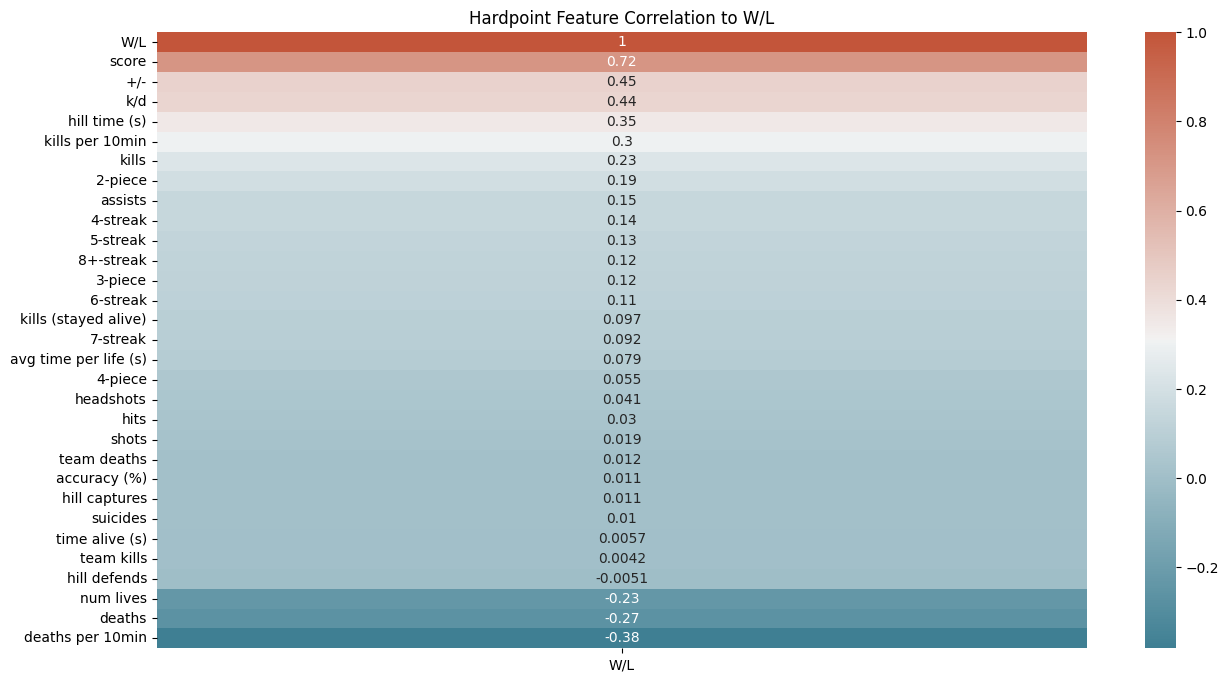

In [7]:
cols = ['W/L', 'score','kills', 'deaths', '+/-', 'k/d', 'kills per 10min', 'deaths per 10min',
'assists', 'headshots', 'suicides', 'team kills', 'team deaths', 'hill captures', 'hill defends', 
'2-piece', '3-piece', '4-piece', 'kills (stayed alive)', 'hits', 'shots', 'accuracy (%)', 'num lives',
'time alive (s)', 'avg time per life (s)', 'hill time (s)',
'4-streak', '5-streak', '6-streak', '7-streak', '8+-streak']

plt.figure(figsize=(15, 8))

sns.heatmap(
    cwl_2018_2019_hp[cols].corr()[['W/L']].sort_values(by=['W/L'],ascending=False),
    annot=True,
    cmap=sns.diverging_palette(220, 20, as_cmap=True)
).set(title='Hardpoint Feature Correlation to W/L');

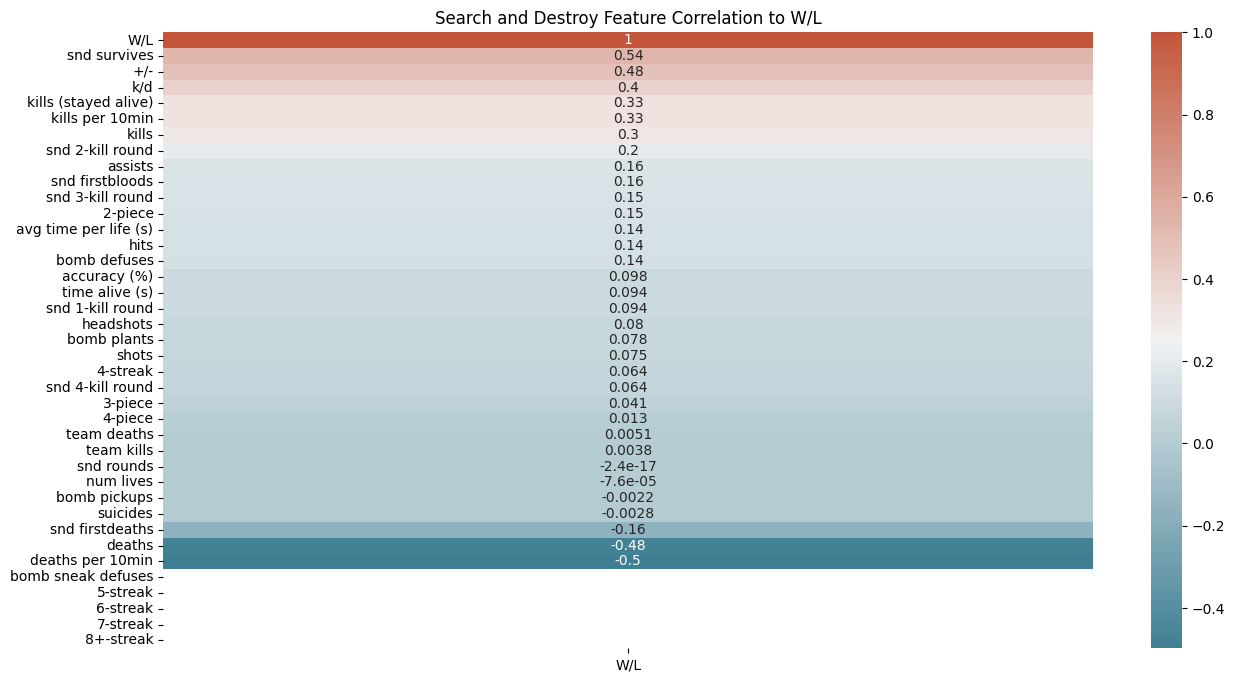

In [8]:
cols = ['W/L',
       'kills', 'deaths', '+/-', 'k/d', 'kills per 10min', 'deaths per 10min',
       'assists', 'headshots', 'suicides', 'team kills', 'team deaths',
       'kills (stayed alive)', 'hits', 'shots', 'accuracy (%)', 'num lives',
       'time alive (s)', 'avg time per life (s)', 'snd rounds',
       'snd firstbloods', 'snd firstdeaths', 'snd survives', 'bomb pickups',
       'bomb plants', 'bomb defuses', 'bomb sneak defuses', 'snd 1-kill round',
       'snd 2-kill round', 'snd 3-kill round', 'snd 4-kill round', '2-piece',
       '3-piece', '4-piece', '4-streak', '5-streak', '6-streak', '7-streak',
       '8+-streak']

plt.figure(figsize=(15, 8))

sns.heatmap(
    cwl_2018_2019_snd[cols].corr()[['W/L']].sort_values(by=['W/L'],ascending=False),
    annot=True,
    cmap=sns.diverging_palette(220, 20, as_cmap=True)
).set(title='Search and Destroy Feature Correlation to W/L');

# Possible Story: SND isn't supposed to be a high kill game, it's an objective game based on planting a bomb. 
# However, the data seems to suggest that time alive and kills are more important. This suggests that people aren't playing the game is intended

In [19]:
px.scatter(
    cwl_2018_2019_hp,
    y = 'k/d',
    x= 'hill time (s)',
    color='team',
    title='Hardpoint: k/d vs. hill time (s)'
)

### Hardpoint: Lasso Regression Model

In [81]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import ConfusionMatrixDisplay

RANDOM_STATE = 42

In [111]:
# select columns of interest
cwl_2018_2019_hp['W/L'] = np.array(np.where(cwl_2018_2019_hp["win?"] == "W", 1, 0)).reshape(-1, 1)

variables = ['kills', 'deaths', '+/-', 'k/d', 'kills per 10min', 'deaths per 10min', 'assists', 'headshots', 
        'suicides', 'team kills', 'team deaths', 'kills (stayed alive)', 'hits', 'shots', 'accuracy (%)', 'num lives', 
        'time alive (s)', 'avg time per life (s)', 'hill captures', 'hill defends', '2-piece', '3-piece', 
        '4-piece','4-streak', '5-streak', '6-streak', '7-streak', '8+-streak', 'W/L']

# drop rows with null values
data_clean = cwl_2018_2019_hp[variables].dropna()

# split clean data into variables
X = data_clean.iloc[:,:-1]
y = data_clean.iloc[:,-1:]

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=RANDOM_STATE)

In [31]:
# fit model with unnormalized data (prolly want to do StandardScaler)
lasso_model = Lasso().fit(X_train,y_train)

In [32]:
lasso_model.intercept_

array([0.21944304])

In [33]:
lasso_model.coef_

array([ 0.00000000e+00, -0.00000000e+00,  5.62438993e-03,  0.00000000e+00,
        0.00000000e+00, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  2.04698240e-05,  0.00000000e+00, -0.00000000e+00,
       -1.74110005e-05,  0.00000000e+00,  4.47606784e-03, -0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00])

In [34]:
lasso_model.predict(X_train)[:5]

array([0.57649737, 0.48950627, 0.82821867, 0.52918287, 0.39306537])

In [36]:
lasso_model.predict(X_test)[:5]

array([0.71720045, 0.50014368, 0.44850505, 0.30668811, 0.45346411])

In [37]:
y_pred = lasso_model.predict(X_test)
np.sqrt(mean_squared_error(y_test,y_pred))

0.45666244693487046

In [38]:
r2_score(y_test, y_pred)

0.16582423020168024

### Hardpoint - Decision Tree Classifiers

#### Normal Decision Tree

In [ ]:
# TODO: # look at limiting max_depth or max_leaf_nodes and min_samples to reduce overfitting on training data

In [87]:
from sklearn import tree

# init and fit classifier
dtc_clf = tree.DecisionTreeClassifier(max_depth=5, random_state=RANDOM_STATE).fit(X_train, y_train)

In [88]:
# get list of top 10 features and their importance
feat_scores = list(zip(X_train.columns.tolist(), dtc_clf.feature_importances_))
feat_scores.sort(key=lambda x: x[1], reverse=True)
feat_scores[:10]

[('k/d', 0.6254397103381506),
 ('hill time (s)', 0.17962439466582847),
 ('assists', 0.06614420896237223),
 ('deaths', 0.04801657568274149),
 ('+/-', 0.03726983824690811),
 ('deaths per 10min', 0.0327270167469717),
 ('kills per 10min', 0.006166509841990365),
 ('hill defends', 0.004611745515037021),
 ('kills', 0.0),
 ('headshots', 0.0)]

In [89]:
scores = []
for i in range(1,11):
    clf = tree.DecisionTreeClassifier(max_depth=i, random_state=0).fit(X_train, y_train)
    scores.append((clf.score(X_train, y_train), clf.score(X_test, y_test)))

scores

[(0.6949455899198167, 0.6938717067583047),
 (0.6949455899198167, 0.6938717067583047),
 (0.7099799541809851, 0.6993127147766323),
 (0.7256586483390607, 0.7162084765177549),
 (0.7342497136311569, 0.7196449026345934),
 (0.739762313860252, 0.7147766323024055),
 (0.7582331042382588, 0.720504009163803),
 (0.7763459335624284, 0.7147766323024055),
 (0.7973940435280642, 0.7116265750286369),
 (0.8197308132875143, 0.711340206185567)]


 Recall : 0.7809085681426107

 TN : 1155 
 FP : 598 
 FN : 381 
 TP : 1358


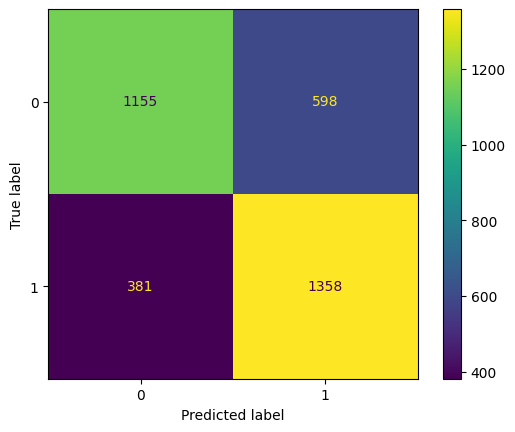

In [90]:
y_pred=dtc_clf.predict(X_test)

tn,fp,fn,tp=confusion_matrix(y_test,y_pred).ravel()
recall=recall_score(y_test,y_pred)
precision=precision_score(y_test,y_pred)
print('\n', f'Recall : {recall}')
print('\n', f'TN : {tn}', '\n', f'FP : {fp}', '\n', f'FN : {fn}', '\n', f'TP : {tp}')

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

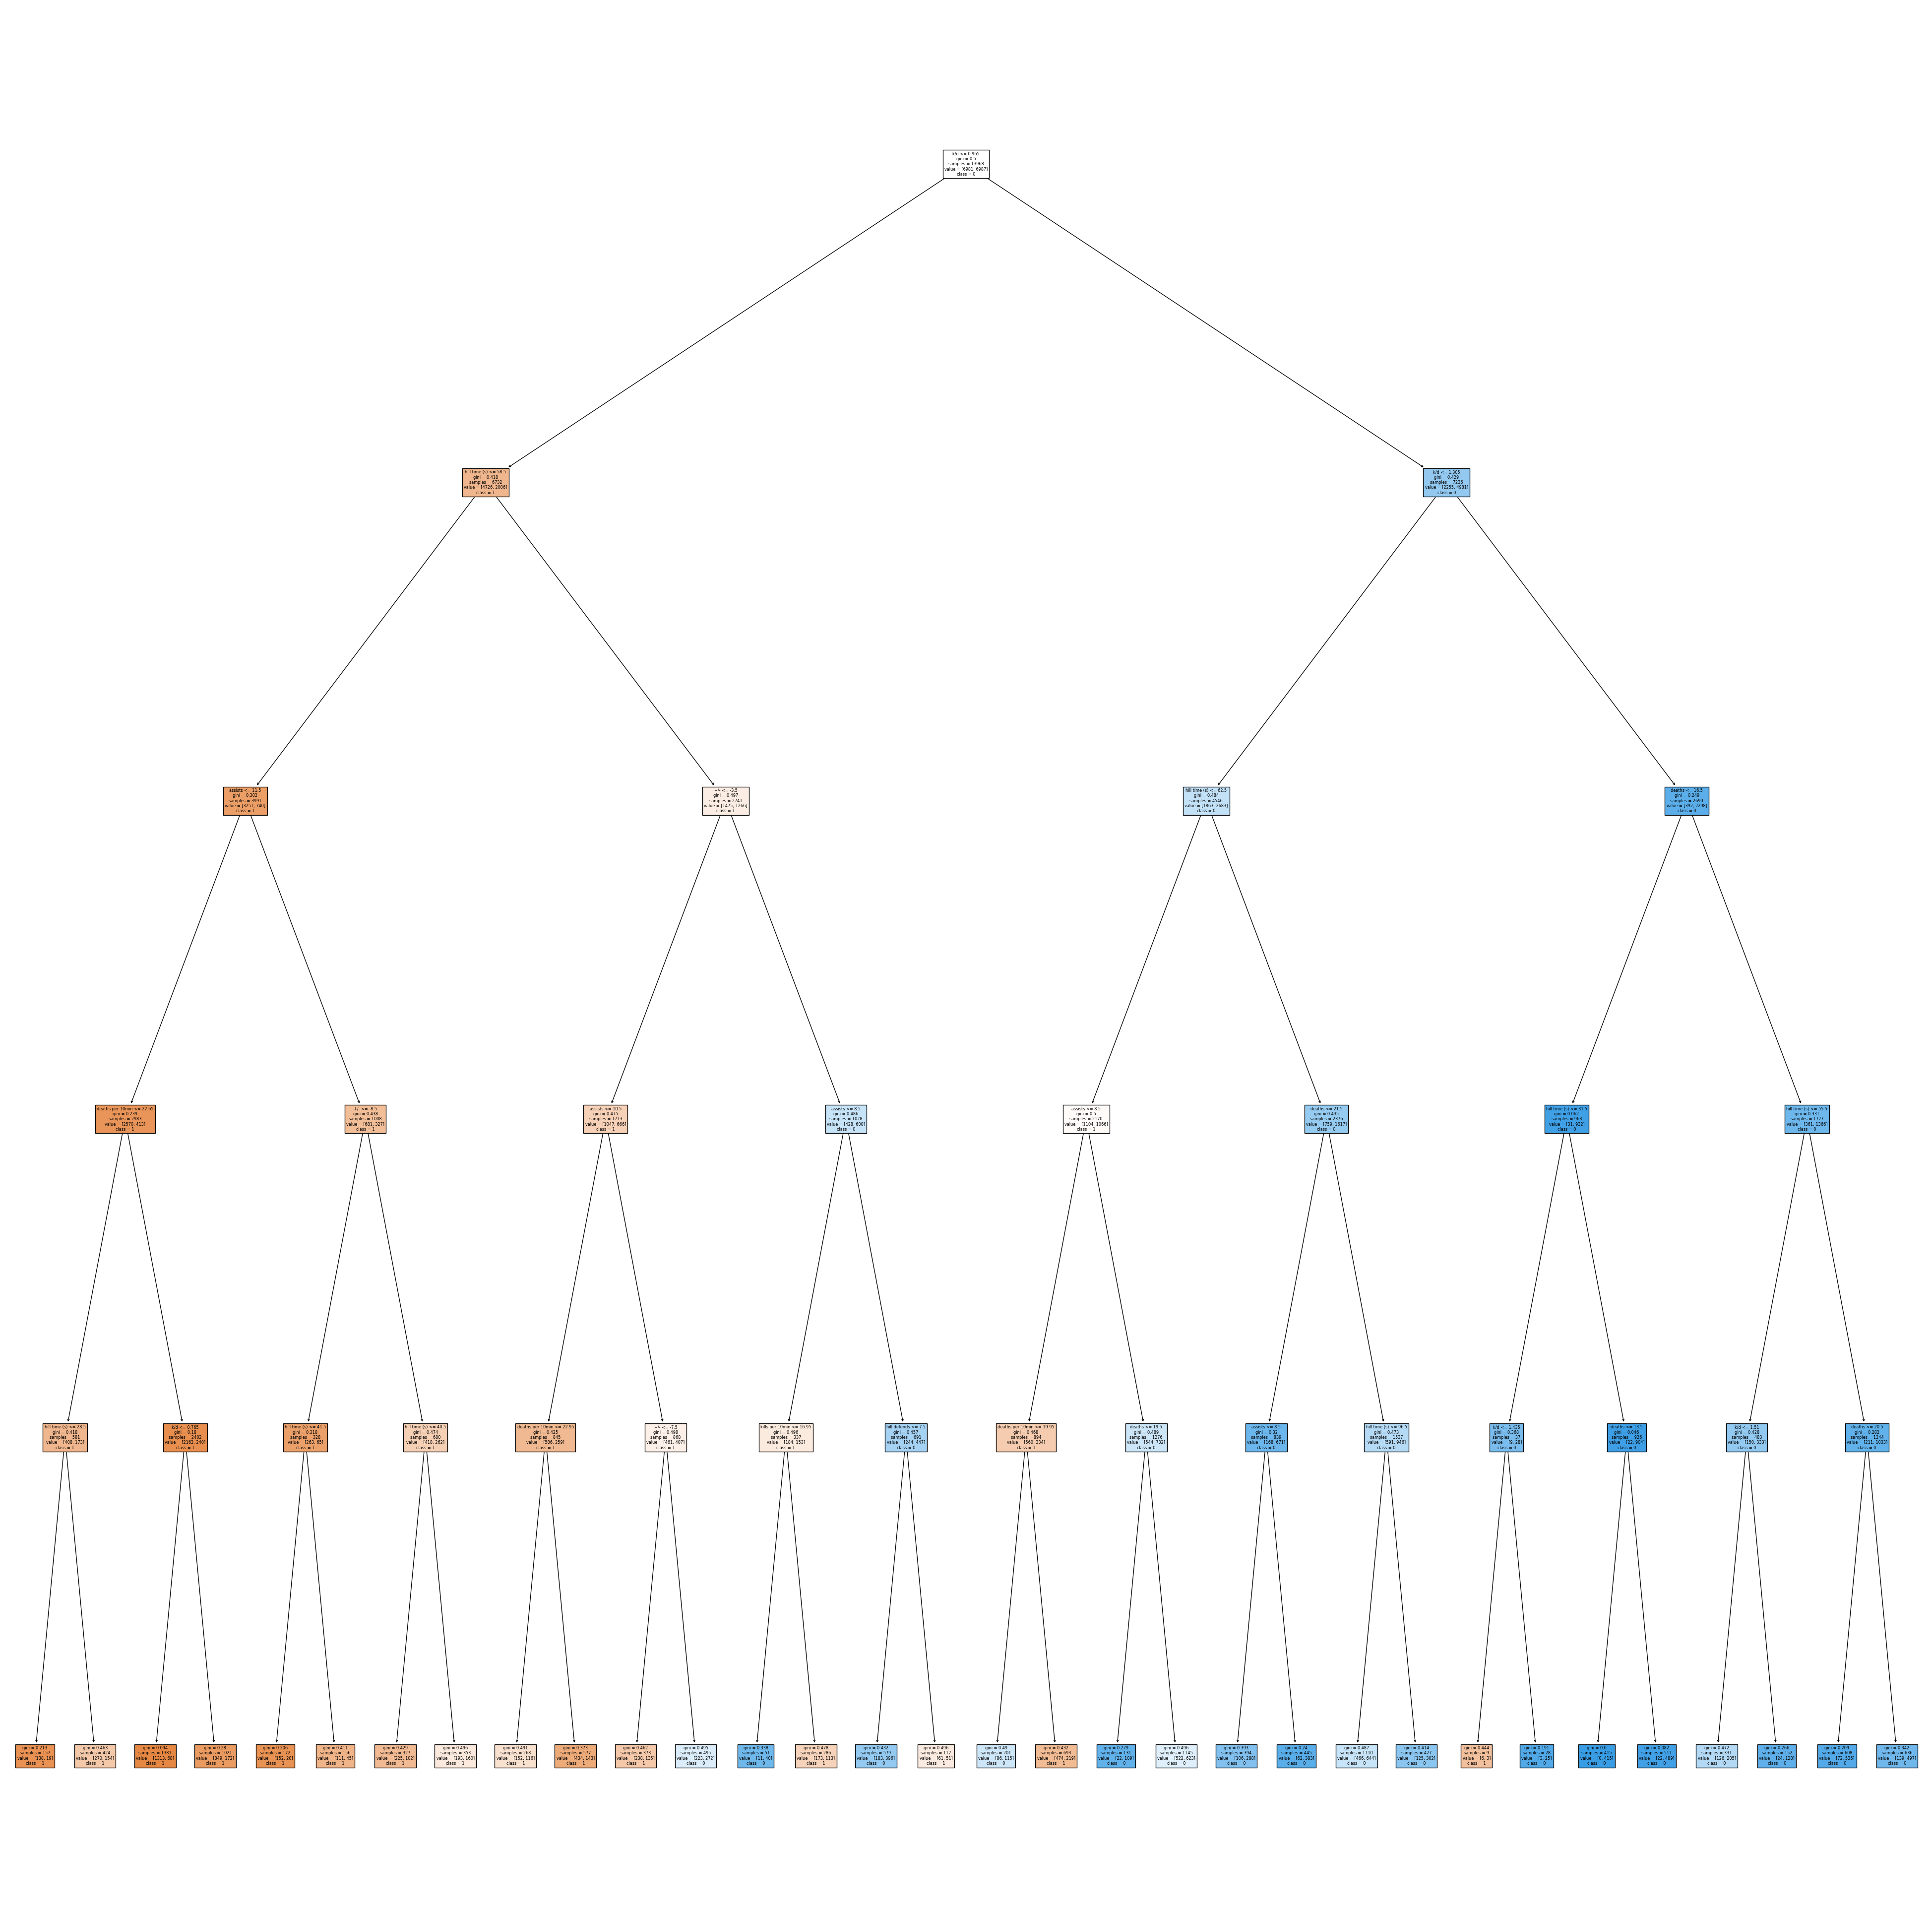

In [94]:
fig = plt.figure(figsize=(50,50))
_ = tree.plot_tree(dtc_clf, 
                   feature_names=X_train.columns.tolist(),  
                   class_names=['1','0'],
                   filled=True)

#### Gradient Boosted Classifier

In [83]:
from sklearn.ensemble import GradientBoostingClassifier

gbrt = GradientBoostingClassifier(random_state=RANDOM_STATE).fit(X_train, y_train)
results = gbrt.score(X_train, y_train), gbrt.score(X_test, y_test)

/Users/christopherfiore/Documents/GitHub/cwl-data/venv/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [84]:
# look at list of feats and their importance
feat_scores = list(zip(X_train.columns.tolist(), gbrt.feature_importances_))
feat_scores.sort(key=lambda x: x[1], reverse=True)
feat_scores[:10]

[('k/d', 0.4277553330108623),
 ('hill time (s)', 0.1867996821744206),
 ('assists', 0.10245957246875453),
 ('+/-', 0.0799472056602208),
 ('deaths', 0.07532890770677124),
 ('deaths per 10min', 0.05292524409600588),
 ('hill defends', 0.02797087394467781),
 ('time alive (s)', 0.013523532994231213),
 ('kills per 10min', 0.009605910242902773),
 ('hits', 0.0043889085774726205)]

In [85]:
results

(0.7605956471935853, 0.7402634593356243)


 Recall : 0.7590569292696953

 TN : 1265 
 FP : 488 
 FN : 419 
 TP : 1320


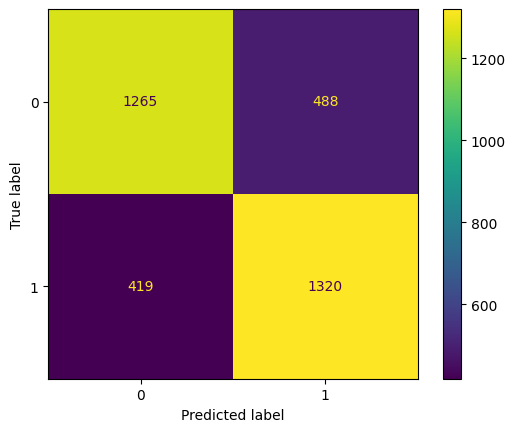

In [86]:
y_pred=gbrt.predict(X_test)

tn,fp,fn,tp=confusion_matrix(y_test,y_pred).ravel()
recall=recall_score(y_test,y_pred)
precision=precision_score(y_test,y_pred)
print('\n', f'Recall : {recall}')
print('\n', f'TN : {tn}', '\n', f'FP : {fp}', '\n', f'FN : {fn}', '\n', f'TP : {tp}')
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

#### Hardpoint: Random Forest

In [112]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(random_state=RANDOM_STATE).fit(X_train, y_train)

print(f"RF train accuracy: {rf_clf.score(X_train, y_train):.3f}")
print(f"RF test accuracy: {rf_clf.score(X_test, y_test):.3f}")

/var/folders/zm/xn8kj8792x12gxb9yzjclh0m0000gp/T/ipykernel_74163/3343723131.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_clf = RandomForestClassifier(random_state=RANDOM_STATE).fit(X_train, y_train)


RF train accuracy: 1.000
RF test accuracy: 0.716


##### Feature Importances:
1. [MDI Importance](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html) - suffers from bias with high cardinality features because it looks at how feature affect split points in forrest.
2. [Permutation feature importance](https://scikit-learn.org/stable/modules/permutation_importance.html#permutation-importance)
3. [Permutation Importance vs Random Forest Feature Importance (MDI)](https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-py)


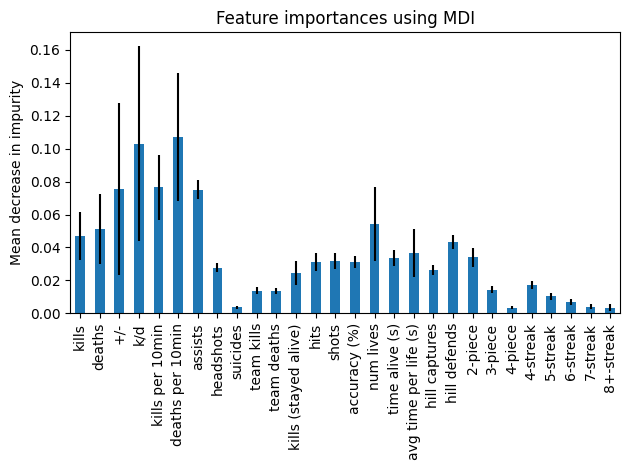

In [113]:
importances = rf_clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_clf.estimators_], axis=0)

forest_importances = pd.Series(importances, index=X_train.columns.tolist())

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

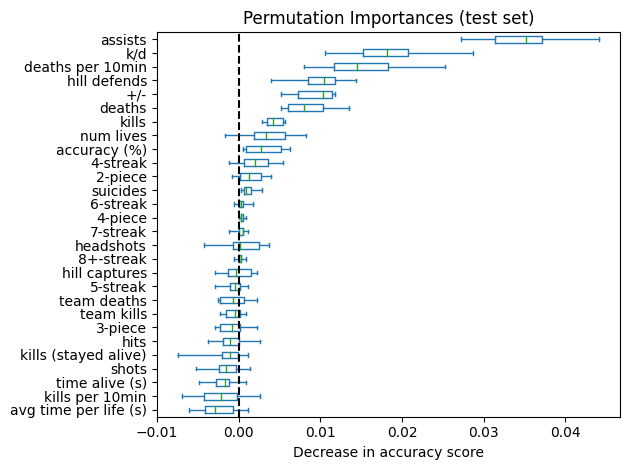

In [114]:
result = permutation_importance(
    rf_clf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()


/Users/christopherfiore/Documents/GitHub/cwl-data/venv/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


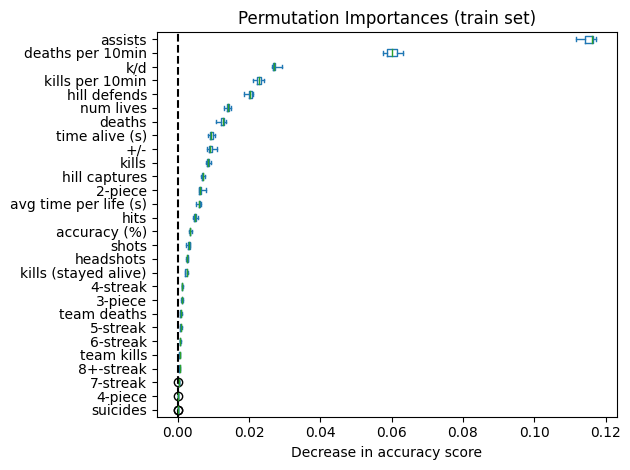

In [115]:
result = permutation_importance(
    rf_clf, X_train, y_train, n_repeats=10, random_state=42, n_jobs=2
)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (train set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

### Logistic Regression Classifier